# import modules

In [1]:
import keras
from keras.utils import plot_model,to_categorical
from keras import Model,Input,regularizers
from keras.layers import Reshape,Flatten
import numpy as np
from sklearn.model_selection import train_test_split
import keras.backend as K
import keras.callbacks as kcallbacks
from sklearn.preprocessing import LabelEncoder
import string
from keras.optimizers import SGD
import warnings
import tensorflow as tf
# from lsuv_init import LSUVinit
warnings.filterwarnings('ignore')
from tensorflow.keras import layers
from keras.layers import Input, Dense, LSTM, merge ,Conv1D,Dropout,Bidirectional,Multiply,BatchNormalization,MaxPool1D
from keras.models import Model
import time

from attention_utils import get_activations
from keras.layers import merge
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *

import  pandas as pd
import  numpy as np
from keras.wrappers import scikit_learn

Using TensorFlow backend.
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/py37/lib/python3.7/site-packag

# Load Features

In [2]:
X_features=np.load('X_gabor.npy')
y=np.load('y_pinyin.npy')

In [3]:
X_features.shape

(4704, 35, 7)

In [4]:
y.shape

(4704, 5)

In [5]:
print(y)

[[ 2  1  0  0  0]
 [ 4  1  0  0  0]
 [ 5 18  0  0  0]
 ...
 [25 21  1 14  0]
 [25 21  0  0  0]
 [26  1 15  0  0]]


In [6]:
alphabet_set=list(string.ascii_letters[:26])

In [7]:
alphabet_set.insert(0,'0')

In [8]:
len(alphabet_set)

27

## One-hot Encoding

In [9]:
y=to_categorical(y,num_classes=27)

In [10]:
y.shape

(4704, 5, 27)

## split train and test

In [12]:
np.random.seed(116)
np.random.shuffle(X_features)
np.random.seed(116)
np.random.shuffle(y)
#tf.random.set_seed(116)
tf.set_random_seed(116)

In [13]:
X_train, X_test, y_train, y_test=train_test_split(X_features,y,test_size=0.1,random_state=2019)

In [14]:
X_train.shape,X_test.shape

((4233, 35, 7), (471, 35, 7))

In [15]:
y_train.shape,y_test.shape

((4233, 5, 27), (471, 5, 27))

In [16]:
X_train.shape

(4233, 35, 7)

In [17]:
X_train.shape

(4233, 35, 7)

# Models


In [18]:
NUM_CLASSES=27
BATCH_SIZE=128
EPOCHS=150
MODEL_SAVE_PATH='.\model\pinyin_gabor_cnn1.h5'
inputs=Input(shape=(35,7))
inputs

<tf.Tensor 'input_1:0' shape=(?, 35, 7) dtype=float32>

In [19]:
SINGLE_ATTENTION_VECTOR = False
def attention_3d_block(inputs, single_attention_vector=False):
    # 如果上一层是LSTM，需要return_sequences=True
    # inputs.shape = (batch_size, time_steps, input_dim)
    time_steps = K.int_shape(inputs)[1]
    input_dim = K.int_shape(inputs)[2]
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax', name='attention')(a)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1))(a)
        a = RepeatVector(input_dim)(a)

    a_probs = Permute((2, 1))(a)
    # 乘上了attention权重，但是并没有求和，好像影响不大
    # 如果分类任务，进行Flatten展开就可以了
    # element-wise
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

def attention_model():
    inputs = Input(shape=(35, 7))
    x=BatchNormalization()(inputs)
    x = Conv1D(filters = 32, kernel_size = 1, padding="same",kernel_initializer='he_normal',
                bias_initializer='zeros',activation = 'relu')(x)  #, padding = 'same'
    x = MaxPool1D()(x)
    #lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    #对于GPU可以使用CuDNNLSTM
    lstm_out = Bidirectional(LSTM(32, return_sequences=True))(x)
    lstm_out = Bidirectional(LSTM(64, return_sequences=True))(lstm_out)
    lstm_out = Bidirectional(LSTM(128, return_sequences=True))(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul=MaxPool1D(pool_size=8,strides=2)(attention_mul)
    output = Dense(27, activation='sigmoid')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model

In [20]:
model = attention_model()
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 35, 7)        0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 35, 7)        28          input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 35, 32)       256         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 17, 32)       0           conv1d_1[0][0]                   
___________________________________________________________________________________________

model = keras.Sequential(
    [
        keras.Input(shape=(35,7)),
        layers.Conv1D(64, kernel_size=1, activation="relu"),
        layers.Dropout(0.3),
        layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
        layers.Dropout(0.5),
        layers.Dense(128, activation="sigmoid"),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation="softmax"),
    ]
)

model.summary()

In [21]:
a=time.time()
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
lr_reduce=kcallbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=6,verbose=1,min_lr=0.00001)
save_model=kcallbacks.ModelCheckpoint(filepath=MODEL_SAVE_PATH,monitor='val_accuracy',verbose=1,save_best_only=True)
callback_list=[save_model,lr_reduce]
history=model.fit(x=X_train,y=y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(X_test,y_test),
                  callbacks=callback_list)
b=time.time()
print("time=",b-a)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 4233 samples, validate on 471 samples
Epoch 1/150
4233/4233 [==============================] - 5s 1ms/step - loss: 3.0642 - accuracy: 0.3712 - val_loss: 2.7838 - val_accuracy: 0.3618

Epoch 00001: val_accuracy improved from -inf to 0.36178, saving model to .\model\pinyin_gabor_cnn1.h5
Epoch 2/150
4233/4233 [==============================] - 3s 744us/step - loss: 2.6136 - accuracy: 0.3802 - val_loss: 2.4780 - val_accuracy: 0.3618

Epoch 00002: val_accuracy did not improve from 0.36178
Epoch 3/150
4233/4233 [==============================] - 3s 773us/step - loss: 2.2872 - accuracy: 0.3802 - val_loss: 2.1246 - val_accuracy: 0.3618

Epoch 00003: val_accuracy did not improve from 0.36178
Epoch 4/150
4233/4233 [==============================] - 3s 744us/step - loss: 1.9986 - accuracy: 0.3802 - val_loss: 1.9206 - val_accuracy: 0.4008

Epoch 00004: val_accuracy improved from 0.36178 to 0.400

4233/4233 [==============================] - 3s 782us/step - loss: 1.2577 - accuracy: 0.5653 - val_loss: 1.3194 - val_accuracy: 0.5423

Epoch 00034: val_accuracy improved from 0.54183 to 0.54225, saving model to .\model\pinyin_gabor_cnn1.h5
Epoch 35/150
4233/4233 [==============================] - 3s 756us/step - loss: 1.2455 - accuracy: 0.5691 - val_loss: 1.2696 - val_accuracy: 0.5490

Epoch 00035: val_accuracy improved from 0.54225 to 0.54904, saving model to .\model\pinyin_gabor_cnn1.h5
Epoch 36/150
4233/4233 [==============================] - 3s 778us/step - loss: 1.2155 - accuracy: 0.5761 - val_loss: 1.2561 - val_accuracy: 0.5529

Epoch 00036: val_accuracy improved from 0.54904 to 0.55287, saving model to .\model\pinyin_gabor_cnn1.h5
Epoch 37/150
4233/4233 [==============================] - 3s 783us/step - loss: 1.1978 - accuracy: 0.5856 - val_loss: 1.2413 - val_accuracy: 0.5597

Epoch 00037: val_accuracy improved from 0.55287 to 0.55966, saving model to .\model\pinyin_gabor_cnn1.


Epoch 00069: val_accuracy improved from 0.63567 to 0.64374, saving model to .\model\pinyin_gabor_cnn1.h5
Epoch 70/150
4233/4233 [==============================] - 3s 734us/step - loss: 0.8715 - accuracy: 0.6968 - val_loss: 1.0608 - val_accuracy: 0.6331

Epoch 00070: val_accuracy did not improve from 0.64374
Epoch 71/150
4233/4233 [==============================] - 3s 744us/step - loss: 0.8745 - accuracy: 0.6958 - val_loss: 1.0687 - val_accuracy: 0.6229

Epoch 00071: val_accuracy did not improve from 0.64374
Epoch 72/150
4233/4233 [==============================] - 3s 752us/step - loss: 0.8661 - accuracy: 0.6972 - val_loss: 1.0604 - val_accuracy: 0.6361

Epoch 00072: val_accuracy did not improve from 0.64374
Epoch 73/150
4233/4233 [==============================] - 3s 748us/step - loss: 0.8483 - accuracy: 0.7025 - val_loss: 1.0178 - val_accuracy: 0.6408

Epoch 00073: val_accuracy did not improve from 0.64374
Epoch 74/150
4233/4233 [==============================] - 3s 740us/step - loss

4233/4233 [==============================] - 3s 755us/step - loss: 0.6357 - accuracy: 0.7869 - val_loss: 0.9993 - val_accuracy: 0.6645

Epoch 00106: val_accuracy did not improve from 0.66539
Epoch 107/150
4233/4233 [==============================] - 3s 781us/step - loss: 0.6407 - accuracy: 0.7822 - val_loss: 0.9985 - val_accuracy: 0.6675

Epoch 00107: val_accuracy improved from 0.66539 to 0.66752, saving model to .\model\pinyin_gabor_cnn1.h5
Epoch 108/150
4233/4233 [==============================] - 3s 749us/step - loss: 0.6368 - accuracy: 0.7864 - val_loss: 0.9950 - val_accuracy: 0.6616

Epoch 00108: val_accuracy did not improve from 0.66752
Epoch 109/150
4233/4233 [==============================] - 3s 797us/step - loss: 0.6382 - accuracy: 0.7849 - val_loss: 0.9979 - val_accuracy: 0.6607

Epoch 00109: val_accuracy did not improve from 0.66752

Epoch 00109: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 110/150
4233/4233 [==============================] - 3s 82

4233/4233 [==============================] - 4s 840us/step - loss: 0.6161 - accuracy: 0.7962 - val_loss: 0.9974 - val_accuracy: 0.6641

Epoch 00144: val_accuracy did not improve from 0.66752
Epoch 145/150
4233/4233 [==============================] - 3s 792us/step - loss: 0.6240 - accuracy: 0.7905 - val_loss: 0.9971 - val_accuracy: 0.6658

Epoch 00145: val_accuracy did not improve from 0.66752
Epoch 146/150
4233/4233 [==============================] - 3s 798us/step - loss: 0.6276 - accuracy: 0.7886 - val_loss: 0.9973 - val_accuracy: 0.6645

Epoch 00146: val_accuracy did not improve from 0.66752
Epoch 147/150
4233/4233 [==============================] - 3s 827us/step - loss: 0.6235 - accuracy: 0.7922 - val_loss: 0.9981 - val_accuracy: 0.6633

Epoch 00147: val_accuracy did not improve from 0.66752
Epoch 148/150
4233/4233 [==============================] - 3s 801us/step - loss: 0.6228 - accuracy: 0.7926 - val_loss: 0.9974 - val_accuracy: 0.6628

Epoch 00148: val_accuracy did not improve fr

## plot_curve

In [22]:
from help import plot_curve,plot_curve_with_smooth

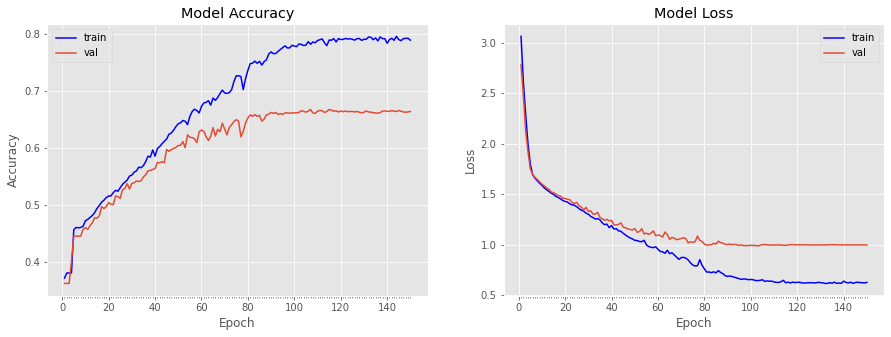

In [23]:
plot_curve(history)

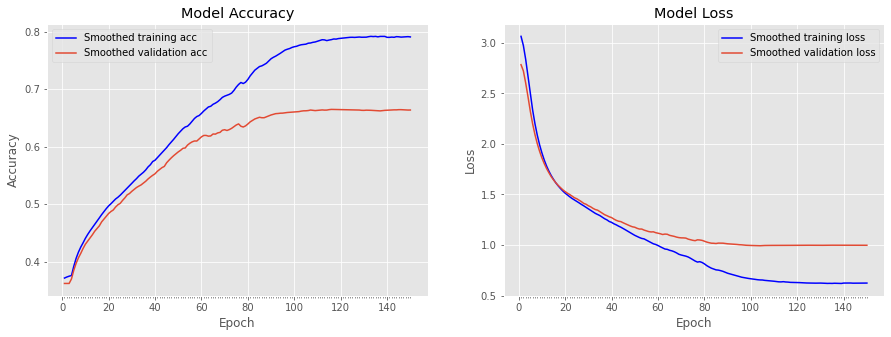

In [24]:
plot_curve_with_smooth(history)

## confusion_metrix

In [26]:
model.load_weights('/Users/lexie/Downloads/WordRecognition/model/pinyin_gabor_cnn1.h5')

AttributeError: 'str' object has no attribute 'decode'

<AxesSubplot:>

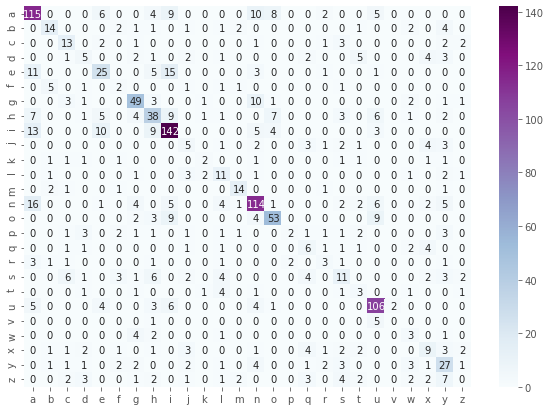

In [27]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
y_pred=model.predict(X_test)
y_pred=np.argmax(y_pred,axis=-1).ravel()
y_true=np.argmax(y_test,axis=-1).ravel()
con_matrix=confusion_matrix(y_true=y_true,y_pred=y_pred)
target_names=[alphabet_set[i] for i in range(1,27)]
con_matrix=con_matrix[1:,1:]
# print(con_matrix)
import seaborn as sn

df_cm = pd.DataFrame(con_matrix,
                     index = [i for i in list(target_names)],
                     columns = [i for i in list(target_names)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='.20g',cmap="BuPu")
# def plot_confusion_matrix(confusion_mat):
#     plt.figure(figsize=(12,8))
#     plt.imshow(confusion_mat)
#     plt.title('Confusion Matrix')
#     plt.colorbar()
#     labels = list(range(0,27))
#     tick_marks = np.arange(len(labels))
#     plt.xticks(tick_marks, labels)
#     plt.yticks(tick_marks, labels)
#     plt.ylabel('True Label')
#     plt.xlabel('Predicted Label')
#     plt.grid(False)
#     plt.show() 
# plot_confusion_matrix(con_matrix)

## classfication_report

In [41]:
from sklearn.metrics import classification_report


In [42]:
target_names=[alphabet_set[i] for i in range(27)]
print(classification_report(y_true,y_pred,digits=4,labels=list(range(27)),target_names=target_names))

              precision    recall  f1-score   support

           0     0.8323    0.9406    0.8832       876
           a     0.6615    0.7175    0.6883       177
           b     0.5143    0.6429    0.5714        28
           c     0.3636    0.2963    0.3265        27
           d     0.2941    0.2174    0.2500        23
           e     0.5455    0.3000    0.3871        60
           f     0.0000    0.0000    0.0000         5
           g     0.5672    0.3016    0.3938       126
           h     0.5269    0.4623    0.4925       106
           i     0.6477    0.6944    0.6702       180
           j     0.3750    0.0938    0.1500        32
           k     0.4000    0.2500    0.3077         8
           l     0.3158    0.4444    0.3692        27
           m     0.3750    0.4286    0.4000        21
           n     0.5580    0.4162    0.4768       185
           o     0.6585    0.6067    0.6316        89
           p     0.0000    0.0000    0.0000        11
           q     0.1739    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# predict test

In [28]:

temp = np.load('che1.npy')
m,n = temp.shape
            #print(m)
if m <=35:
    left = 36 - m
    temp =np.append(temp,(np.zeros([left,n])),axis=0)
test =[]
test.append(temp[:35,])
test = np.array(test)
print(test.shape)
pred=model.predict(test)

pred=np.argmax(pred,axis=-1)[0]
text=[alphabet_set[i] for i in pred]
text=[i for i in text if i!='0']
text=''.join(text)
print('Predict Label:%s'%(text))

(1, 35, 7)
Predict Label:lii


In [29]:

temp = np.load('./gabor/person1_time1_group1_ba_1.npy')
m,n = temp.shape
            #print(m)
if m <=35:
    left = 36 - m
    temp =np.append(temp,(np.zeros([left,n])),axis=0)
test =[]
test.append(temp[:35,])
test = np.array(test)
print(test.shape)
pred=model.predict(test)

pred=np.argmax(pred,axis=-1)[0]
text=[alphabet_set[i] for i in pred]
text=[i for i in text if i!='0']
text=''.join(text)
print('Predict Label:%s'%(text))

FileNotFoundError: [Errno 2] No such file or directory: './gabor/person1_time1_group1_ba_1.npy'

In [86]:

temp = np.load('./gabor/person2_time1_group1_da_4.npy')
m,n = temp.shape
            #print(m)
if m <=35:
    left = 36 - m
    temp =np.append(temp,(np.zeros([left,n])),axis=0)
test =[]
test.append(temp[:35,])
test = np.array(test)
print(test.shape)
pred=model.predict(test)

pred=np.argmax(pred,axis=-1)[0]
text=[alphabet_set[i] for i in pred]
text=[i for i in text if i!='0']
text=''.join(text)
print('Predict Label:%s'%(text))

(1, 35, 7)
Predict Label:maa
